In [1]:
#imports
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
import gc
import time
from scipy.spatial.distance import euclidean
import math
from numba import prange
from numba import jit
import numpy as np
import networkx as nx

In [2]:
#parameters for neighbour determination
NoC=2 #number of components
NoA=[5607,24393] #number of atoms for each component
ndens=0.0284 #number density
file="ge20te80.cfg" #.cfg file containing coordinates
#the end of the file should contain N rows, each coordinate separated by spaces, centered 0 in a 2*2*2 cube
bond_lengths=[0,3.15,3.05] #maximal bond lengths

#parameters for chain analysis
AT=[0,0] #type of beginning ad end atoms
cutoff_dist=5 #maximal chain lengths (the chain contains cutoff_dist+1 atoms)
CS_con=1 #connector of CSES pairs
chain_type=1 #chain type for length distribution

#parameters for ring calculations
max_ring_length=8 #maximum length of rings
ACT=1 #type of homogeneous rings
ABAB_types=[0,1] #ABAB ring types

outp="gete_4.nwa" #output file name

In [3]:
#useful constants
L=2 #lenths of box side in the coordinates
N=sum(NoA) #total number of atoms
a=(N/ndens)**(1/3)/2 # half of box side corresponding to real distances in Angstroms (for conversion)
bond_lengths=list(np.array(bond_lengths)/a) #converting bond lengths from real to in-box distances

#function for data import
def read(file):
    with open(file) as f: #open file
        data=f.readlines() #reading data as lines

    data=data[len(data)-N:] #cutting redundant rows, keeping only the last N rows

    atoms=np.zeros((len(data), 3)) #empty N*3 matrix

    for i in range(len(data)): #for every row
        for j in range(3): #for every coordinate (3D)
            atoms[i,j]=float(data[i].split()[j]) #converting each coordinate to float and store it in a matrix
    return atoms #return with a matrix containing the coordinates

#function for shifting atoms from (0,0,0) to (1,1,1) center
def shift(atoms):
    return atoms+np.ones(np.shape(atoms)) #adding a matrix containing ones

#function to calculate distances
@jit(nopython=True, fastmath=False, parallel=True) #mark function for optimalization, parellel running
def dist_calc(atoms,L):
    distances = np.empty(int(N*(N-1)/2)) #empty array for distances 
    for i in prange(N-1): #parellel range to make it faster
        D=atoms[i]-atoms[i+1:] #each relevant (index>i) atom's coordinates difference from the i.th atom's
        out=np.empty_like(D) #D méretű array
        D=D-np.round(D/L,0,out)*L #periodic boundary conditions for each coordinate
        distance = np.sqrt(np.sum(np.power(D,2), axis=1)) #calculate distance from coordinates
        ind1=int((2*N-i-1)*i/2) #starting index for storing distances
        ind2=int((2*N-i-2)*(i+1)/2) #last index for storing distances
        distances[ind1:ind2]=distance #storing distances in 1D array
    return distances #return with 1D array containing distances

#function to filter distances if they are smaller than the largest possible bond lenth
def pos_ind(dist):
    top=max(bond_lengths) #largest possible bond length
    indices=np.where(dist<=top)[0] #indeces, where distance is shorter than largest possible bond lenth
    values=np.array(list(map(dist. __getitem__, indices) )) #values of possible bond lengths
    return indices,values


#function to convert condensed 1D array index to matrix row index
def calc_row_ind(k, n):
    return int(math.ceil((1/2)*(-(-8*k+4*n**2-4*n-7)**(1/2)+2*n-1)-1))

def elem_in_i_rows(i, n):
    return i * (n - 1 - i) + (i*(i + 1))//2

# function to convert condensed 1D array index to matrix column index
def calc_col_ind(k, i, n):
    return int(n - elem_in_i_rows(i + 1, n) + k)

#function to convert condensed 1D matrix index to 2D matrix indeces
def condensed_to_square(k, n):
    i = calc_row_ind(k, n) #row index
    j = calc_col_ind(k, i, n) #column index
    return i, j

#function to calculate precise bond index constrain
def const(indices):
    co_values=np.zeros(len(indices)) #empty array for cutoff values
    for k in range(len(indices)): #for all possible bonds (can be calculated with pos_ind)
        i,j=condensed_to_square(indices[k],N) #convert 1D index to 2D matrix indeces
        ii=0 #staring index for search of bond type
        stat=True #conditon for the while cycle
        while(stat):
            if(i<sum(NoA[:ii+1])): # if index is smaller the smallest index of the next component, it stops
                stat=False
            else: #else we are not done yet
                ii+=1
        jj=0 #same for the other index
        stat=True
        while(stat):
            if(j<sum(NoA[:jj+1])):
                stat=False
            else:
                jj+=1
                
        var=int((2*NoC-1-ii)/2*ii+jj) #index of bond type
        co_values[k]=bond_lengths[var]     #obtain maximal bond lenth for this bond
    return co_values #return all cutoffs for all possible bonds

#function to determine real bonds
def bonding_a(values,co_values,indices):
    m=values-co_values #cutoff distance substracted from bond distance
    t=m<=0 #where it gives a <=0 value, its within bond range
    bond_ind=np.array(list(map(indices. __getitem__, np.where(t==True)) ))[0] #indices of real bonds
    return bond_ind #return with the indeces of bonds


#function to calculate neighbor matrix, each row contains bonding indeces
def neigh_matrix(bond_ind):
    neigh_m=[[] for i in range(N)] #a list of list, N long
    for k in bond_ind: #for all bonds
        i,j=condensed_to_square(k,N) #calculate the specific atoms they represent
        neigh_m[i].append(j) #add the bond to the apprpriate indeces
        neigh_m[j].append(i)
    return neigh_m #return neighbour matrix

#same as neigh_matrix, only it has no duplicated bond representations
def neigh_matrix_red(bond_ind):
    neigh_m_red=[[] for i in range(N)]
    for k in bond_ind:
        i,j=condensed_to_square(k,N)
        neigh_m_red[i].append(j)
    return neigh_m_red

#function to copy neighbour matix
def neigh_cop(neigh_m): #copy input neighbout matrix
    neigh_mat=[[] for i in range(len(neigh_m))] #create list of equal length
    for i in range(len(neigh_m)): #for every row
        neigh_mat[i]=list(neigh_m[i][:]) #copy row to other list
    return neigh_mat #return with copy

#distribution of coordination numbers and average coordination numbers
def koord_szamok(neigh_mat):
    for i in range(N): #for all atoms in the neigh matrix (all rows)
        for j in range(len(neigh_mat[i])): #for all neighbours
            jj=0 #index
            stat=True
            while(stat):
                if(neigh_mat[i][j]<sum(NoA[:jj+1])): # calculate component represented by index
                    stat=False
                    neigh_mat[i][j]=jj #change atomic index to component index
                else:
                    jj+=1
    
    
    max_kord=6 #maximum coordination number
    koord_szam_m=[np.zeros(max_kord) for i in range(NoC**2)] #list for histograms
    koord_szam_red=[np.zeros(max_kord) for i in range(NoC**2)] #list for reduced histograms
    
    for i in range(NoC): #type of 1st central atom
        for j in range(NoC): #type of 2nd central atom
            temp_arr=np.zeros(NoA[i]) #temporary array to store parcial coordination number of each atom
            for l in range(NoA[i]): #for all atoms type central 1
                kezdo_index=sum(NoA[:i]) #the first index
                temp_arr[l]=sum(map(lambda x : x== j, neigh_mat[kezdo_index+l])) #the sought parcial coord. num.
            koord_szam_m[NoC*i+j]=np.histogram(temp_arr, bins=max_kord, range=(0,max_kord))[0] #histogram drom data
            koord_szam_red[NoC*i+j]=koord_szam_m[NoC*i+j]/sum(koord_szam_m[NoC*i+j])
    
    
    kord_av=[0 for i in range(2*NoC)] #list for average coordination numbers
    for i in range(2*NoC): #minden párra
        for j in range(max_kord): #minden koordinacios szamra
            kord_av[i]+=koord_szam_m[i][j]*j/NoA[math.floor(i/NoC)] #all bonds divided by number of atoms
    
    return koord_szam_m,koord_szam_red, kord_av #return with distributoion and average coordination number

#function for making a graph
def graph_gen(neigh_m_red):
    G=nx.Graph() #empty graph made

    for i in range(N): #Adding the sufficient number of nodes
        G.add_node(i)

    for i in range(N-1): #for all atoms (the last one is not necessary)
        for j in neigh_m_red[i]: #bonds from reduced neighbour matrix
            G.add_edge(i,j) #adding edges
    return G #return the completed graph

#lánckeresés, két adott típus között, csak egy, ha van több!!
def chain(G,AT,cutoff_dist):
    ind1=sum(NoA[:AT[0]]) #a kezdő atomot megelőző atomok száma
    ind2=sum(NoA[:AT[1]]) #a végső atomot megelőző atomok száma
    ind3=sum(NoA[:AT[1]+1]) #az utolsó végső atom indexe +1
    seeked_paths=[]
    for i in range(NoA[AT[0]]): #az összes keresett első atom útvonalai
        path = list(nx.single_source_shortest_path(G, ind1+i,cutoff_dist).items()) #útvonalak elemei listában
        for j in range(len(path)): #a talált láncokon végigmenve
            if(path[j][1][-1]>=ind2 and path[j][1][-1]<ind3 and path[j][1][-1]!=ind1+i): 
                seeked_paths.append(path[j][1]) #ha a lánc vége a keresett atom, de nem önmaga
    return seeked_paths

#function to find length of shortest route
def chain_lengths(G,AT,cutoff_dist):
    ind1=sum(NoA[:AT[0]]) #number of atoms preceding the first atom type
    ind2=sum(NoA[:AT[1]]) #number of atoms preceding the second atom type
    ind3=sum(NoA[:AT[1]+1]) #index of the last 2. type atom +1
    seeked_paths_lengths=[]
    for i in range(NoA[AT[0]]): #for all type AT[0] atoms
        path = list(nx.single_source_shortest_path_length(G, ind1+i,cutoff_dist).items()) #length of all shortest routes
        for j in range(len(path)): #for every found chain
            if(path[j][0]>=ind2 and path[j][0]<ind3 and path[j][1]!=0): 
                seeked_paths_lengths.append([i,path[j][0],path[j][1]]) #if it ends with the given type but not itself
    return seeked_paths_lengths #return the filtered path list

#function to calculate all chains under given length between the above found endpoints, compute shortest paths too
def all_chain(seeked_paths_lengths,cutoff_dist):
    all_paths=[] #list for the paths
    all_paths_shortest=[] #list fot only the shortest paths
    for i in range(len(seeked_paths_lengths)): #between all possible endpoints
        path = list(nx.all_simple_paths(G, seeked_paths_lengths[i][0],seeked_paths_lengths[i][1],cutoff_dist)) #elements of path
        shortest_dist=cutoff_dist+1 #length of shortest route (initialized variable)
        for j in range(len(path)): #iterating through the found paths
            all_paths.append(path[j]) #storing every element is a list in a list
            if(len(path[j])<shortest_dist): #if shorter route found
                shortest_dist=len(path[j]) #overwrite lenght
        for j in range(len(path)): #for every found path
            if(len(path[j])==shortest_dist): #if length equals shortest length
                 all_paths_shortest.append(path[j]) #storing shortest paths in list
                
    return all_paths,all_paths_shortest #return all possible paths

#function for CSES connection calculation
def CSES(CT,all_paths,CS_con):
    all_paths=all_paths[0]
    for i in range(len(all_paths)):
        if(all_paths[i][1]<sum(NoA[:CS_con]) or all_paths[i][1]>=sum(NoA[:CS_con+1])): #if the interconnecting atom is not sufficient
            all_paths=np.delete(all_paths, i, 0) #delete it from the list
    max_pairs=10 #maximum number of pairs per atom
    CSESFS=np.zeros((NoA[CT],3)) #1/2/3 pár
    counter=0 #counter for the number of connections
    for j in range(len(all_paths)-1): #iterating through every neighbour
        if(all_paths[j][0]==all_paths[j+1][0] and all_paths[j][-1]==all_paths[j+1][-1]): #if endpoints match
            counter+=1 #number of counter risis
        else:
            CSESFS[all_paths[j][0],counter]+=1 #if they differ, it is added to the distribution
            counter=0
    CSESFS[-1,counter]+=1 #correction for the last element of the list
    ret1=np.histogram(CSESFS[:,0], bins=max_pairs,range=(0,max_pairs))[0] #histograms
    ret2=np.histogram(CSESFS[:,1], bins=max_pairs,range=(0,max_pairs))[0]
    ret3=np.histogram(CSESFS[:,2], bins=max_pairs,range=(0,max_pairs))[0]
    return ret1,ret2,ret3 

#a function to obtain chain lenght distribution connecting AT, made of chain_type, all chains and
def chain_length_dist(all_paths,chain_type):
    indeces=np.array([i for i in range(len(all_paths))]) #list with its own indexes with length len(all_paths)
    for i in range(len(all_paths)): #for every path
        for j in all_paths[i][1:-1]: #for every element of the path, first and last excluded as being of different type
            if(j<sum(NoA[:chain_type]) or j>=sum(NoA[:chain_type+1])): #if one of the indeces is too small
                indeces[i]=-1 #marking bad indeces
                break #no more iteration needed
    length_dist=np.zeros(cutoff_dist) #array for length distribution
    for i in indeces: #for every index
        if(i>=0): #if index is not bad
            length_dist[len(all_paths[i])-2]+=1 #add to histogram with respect to length
    return length_dist[1:]/2 #return histogram, starting with length 1, divide by two to avoid double counting


#function to find rings
def find_rings(neigh_m): #calculating rings from neighbour matrix
    cycles=[] #empy list for rings
    for i in range(len(neigh_m)): #for every node point
        for j in neigh_m[i]: #for every neightbour of the node
            temp_cycles=list(nx.all_simple_paths(G, i,j,max_ring_length-1)) #calculate cycles, counting start atom into length
            if(len(temp_cycles)>1): #if there exists a route other than the trivial ones
                cycles.append(temp_cycles) #saving possible routes in a list    
    return cycles #return with every non-trivial routes

#function to calculate homo ring lensth distribution
def homo_rings(cycles,ACT): #function of rings and ring type
    cycle_hist=np.zeros(max_ring_length+1) #empty array for histograms
    for i in range(len(cycles)): #for every endpoint
        for j in cycles[i]: #for every cycle
            if(all((np.array(j)-sum(NoA[:ACT]))>=0)==True and all((np.array(j)-sum(NoA[:ACT+1]))<0)==True):#conditon for ring type
                cycle_hist[len(j)]+=1/(2*len(j)) #adding 1 to the relevant histogram bin, divide by 2*length (double*multiple counting)
    return list(np.array(cycle_hist[3:])) #starting with lentgh 3 (others are irrelevant), index 2 contains spam

#function to calculate ABAB rings
def ABAB_rings(cycles):
    ABAB_cycle_hist=np.zeros(max_ring_length+1) #empty array for histograms
    for i in range(len(cycles)): #for every endpoint
        for j in cycles[i]: #for every cycle
            A_type=[] #list for type A atoms
            B_type=[] #list for type B atoms
            if(len(j)%2==0): #if No atoms in ring is even (condition for ring)
                for k in range(len(j)): # for every element of ring
                    if(k%2==0): #if index is even
                        A_type.append(j[k]) #it is type A then
                    elif(k%2==1): #if index is odd
                        B_type.append(j[k]) #index belongs to type B
                #condition for the types of atoms in list A_type and B_type
                if(all((np.array(A_type)-sum(NoA[:ABAB_types[0]]))>=0)==True and all((np.array(A_type)-sum(NoA[:ABAB_types[0]+1]))<0)==True):#conditon for ring type
                    if(all((np.array(B_type)-sum(NoA[:ABAB_types[1]]))>=0)==True and all((np.array(B_type)-sum(NoA[:ABAB_types[1]+1]))<0)==True):#conditon for ring type
                        ABAB_cycle_hist[len(j)]+=1/(2*len(j)) #adding 1 to the relevant histogram bin, divide by 2*length (double*multiple counting)
                #it can also be the other way (BABA rings)
                elif(all((np.array(B_type)-sum(NoA[:ABAB_types[0]]))>=0)==True and all((np.array(B_type)-sum(NoA[:ABAB_types[0]+1]))<0)==True):#conditon for ring type
                    if(all((np.array(A_type)-sum(NoA[:ABAB_types[1]]))>=0)==True and all((np.array(A_type)-sum(NoA[:ABAB_types[1]+1]))<0)==True):#conditon for ring type
                        ABAB_cycle_hist[len(j)]+=1/(2*len(j)) #adding 1 to the relevant histogram bin, divide by 2*length (double*multiple counting)
    return ABAB_cycle_hist[4:] #return with histogram, starting with length 4

#function to calculate all ring legth distribution
def ring_dist(cycles): #function of rings and ring type
    all_cycle_hist=np.zeros(max_ring_length+1) #empty array for histograms
    for i in range(len(cycles)): #for every endpoint
        for j in cycles[i]: #for every cycle
            all_cycle_hist[len(j)]+=1/(2*len(j)) #adding 1 to the relevant histogram bin, divide by 2*length (double*multiple counting)
    return list(np.array(all_cycle_hist[3:])) #starting with lentgh 3 (others are irrelevant), index 2 contains spam

#function to filter primitive cycles from all cycles
def prim_cyc_calc(cycles):
    primitive_cycles=[[]] #list for primitive cycles
    for i in range(len(cycles)): #for every endpoint
        for j in cycles[i]: #for every cycle
            is_primitive_cycle=True
            length=len(j) #length of cycle
            if(length>2): #length 2 "rings" are brock, can be excluded
                if(length%2==0): #if length is even
                    n=int(length/2) #half of length
                    for k in range(n): #distance of every node-midnode pair
                        if(nx.shortest_path_length(G, source=j[k], target=j[k+n])!=n): #if ring path is not shortest
                            is_primitive_cycle=False #not a primitive cycle
                            break #investigation can be ended                    
                elif(length%2==1): #if length is odd
                    n=int((length-1)/2) #half of length rounded down
                    for k in range(n+1): #investigate all node-midnode relation
                        if(nx.shortest_path_length(G, source=j[k], target=j[k+n])!=n): #if not shortest path to first midnode
                            is_primitive_cycle=False #not a primitive cycle
                            break #investigation can be ended
                        if(k!=n): #if its the last one, one mid node has already been investigated
                            if(nx.shortest_path_length(G, source=j[k], target=j[k+n+1])!=n):  #if not shortest path to second mid-node
                                is_primitive_cycle=False #not a primitive cycle
                                break #investigation can be ended
                if(is_primitive_cycle==True): #if cycle is primitive
                    primitive_cycles[0].append(j) #store primitive cycle
    return primitive_cycles #return with value

# function to analyse length 4 rings
def ring4(cycles):
    AAAB=0 #0-0-0-1
    AABB=0 #0-0-1-1
    ABBB=0 #0-1-1-1
    for i in range(len(cycles)): #for every endpoint
        for j in cycles[i]: #for every cycle
            if(len(j)==4):
                bin_count=0
                if(((j[0]-sum(NoA[:ABAB_types[0]]))>=0)==True and ((j[0]-sum(NoA[:ABAB_types[0]+1]))<0)==True): #if 0. is type 0 add 1
                    bin_count+=1
                if(((j[1]-sum(NoA[:ABAB_types[0]]))>=0)==True and ((j[1]-sum(NoA[:ABAB_types[0]+1]))<0)==True): #if 1. is type 0 add 2
                    bin_count+=2
                if(((j[2]-sum(NoA[:ABAB_types[0]]))>=0)==True and ((j[2]-sum(NoA[:ABAB_types[0]+1]))<0)==True): #if 2. is type 0 add 3
                    bin_count+=4
                if(((j[3]-sum(NoA[:ABAB_types[0]]))>=0)==True and ((j[3]-sum(NoA[:ABAB_types[0]+1]))<0)==True): #if 3. is type 0 add 4
                    bin_count+=8

                if(bin_count==1): #if only 1. is type 0
                    ABBB+=1
                if(bin_count==3): #1. and 2. is type 0
                    AABB+=1
                if(bin_count==7): #1. 2. and 3. is type 0
                    AAAB+=1
    return AAAB/2,AABB/2,ABBB/2 #0001, 0011, 0111

# function to analyse length 5 rings
def ring5(cycles):
    AAAAB=0 #0-0-0-0-1
    AAABB=0 #0-0-0-1-1
    AABBB=0 #0-0-1-1-1
    ABBBB=0 #0-1-1-1-1
    
    ABABA=0 #0-1-0-1-0
    ABABB=0 #0-1-0-1-0
    
    for i in range(len(cycles)): #for every endpoint
        for j in cycles[i]: #for every cycle
            if(len(j)==5):
                bin_count=0
                if(((j[0]-sum(NoA[:ABAB_types[0]]))>=0)==True and ((j[0]-sum(NoA[:ABAB_types[0]+1]))<0)==True): #if 0. is type 0 add 1
                    bin_count+=1
                if(((j[1]-sum(NoA[:ABAB_types[0]]))>=0)==True and ((j[1]-sum(NoA[:ABAB_types[0]+1]))<0)==True): #if 1. is type 0 add 2
                    bin_count+=2
                if(((j[2]-sum(NoA[:ABAB_types[0]]))>=0)==True and ((j[2]-sum(NoA[:ABAB_types[0]+1]))<0)==True): #if 2. is type 0 add 3
                    bin_count+=4
                if(((j[3]-sum(NoA[:ABAB_types[0]]))>=0)==True and ((j[3]-sum(NoA[:ABAB_types[0]+1]))<0)==True): #if 3. is type 0 add 4
                    bin_count+=8
                if(((j[4]-sum(NoA[:ABAB_types[0]]))>=0)==True and ((j[4]-sum(NoA[:ABAB_types[0]+1]))<0)==True): #if 3. is type 0 add 4
                    bin_count+=16

                if(bin_count==1): #if only 1. is type 0
                    ABBBB+=1
                if(bin_count==3): #1. and 2. is type 0
                    AABBB+=1
                if(bin_count==7): #1. 2. and 3. is type 0
                    AAABB+=1
                if(bin_count==15): #1. 2. 3. and 4. is type 0
                    AAAAB+=1
                if(bin_count==21): #1. 3. and 5. is type 0
                    ABABA+=1
                if(bin_count==5): #1. and 3. is type 0
                    ABABA+=1
                   
    return AAAAB/2,AAABB/2,AABBB/2, ABBBB/2, ABABA/2,ABABB/2 #00001, 00011, 00111, 01111, 01010, 01011

#function to analyse length 6 rings
def ring6(cycles):
    AAAAAB=0 #0-0-0-0-0-1
    AAAABB=0 #0-0-0-0-1-1
    AABAAB=0 #0-0-1-0-0-1
    ABAAAB=0 #0-1-0-0-0-1
    AAABBB=0 #0-0-0-1-1-1
    ABAABB=0 #0-1-0-0-1-1
    AABBBB=0 #0-0-1-1-1-1
    ABABBB=0 #0-1-0-1-1-1
    ABBABB=0 #0-1-1-0-1-1
    ABBBBB=0 #0-1-1-1-1-1
    
    for i in range(len(cycles)): #for every endpoint
        for j in cycles[i]: #for every cycle
            if(len(j)==6):
                bin_count=0
                if(((j[0]-sum(NoA[:ABAB_types[0]]))>=0)==True and ((j[0]-sum(NoA[:ABAB_types[0]+1]))<0)==True): #if 0. is type 0 add 1
                    bin_count+=1
                if(((j[1]-sum(NoA[:ABAB_types[0]]))>=0)==True and ((j[1]-sum(NoA[:ABAB_types[0]+1]))<0)==True): #if 1. is type 0 add 2
                    bin_count+=2
                if(((j[2]-sum(NoA[:ABAB_types[0]]))>=0)==True and ((j[2]-sum(NoA[:ABAB_types[0]+1]))<0)==True): #if 2. is type 0 add 3
                    bin_count+=4
                if(((j[3]-sum(NoA[:ABAB_types[0]]))>=0)==True and ((j[3]-sum(NoA[:ABAB_types[0]+1]))<0)==True): #if 3. is type 0 add 4
                    bin_count+=8
                if(((j[4]-sum(NoA[:ABAB_types[0]]))>=0)==True and ((j[4]-sum(NoA[:ABAB_types[0]+1]))<0)==True): #if 4. is type 0 add 4
                    bin_count+=16
                if(((j[5]-sum(NoA[:ABAB_types[0]]))>=0)==True and ((j[4]-sum(NoA[:ABAB_types[0]+1]))<0)==True): #if 5. is type 0 add 4
                    bin_count+=32

                if(bin_count==1): #if only 1. is type 0
                    ABBBBB+=1
                if(bin_count==3): #1. and 2. is type 0
                    AABBBB+=1
                if(bin_count==5): #1. and 3. is type 0
                    ABABBB+=1
                if(bin_count==9): #1. and 4. is type 0
                    ABBABB+=1
                if(bin_count==7): #1. 2. and 3. is type 0
                    AAABBB+=1
                if(bin_count==13): #1. 3. and 4. is type 0
                    ABAABB+=1
                if(bin_count==29): #1. 3. 4. and 5. is type 0
                    ABAAAB+=1
                if(bin_count==27): #1. 2. 4. and 5. is type 0
                    AABAAB+=1
                if(bin_count==15): #1. 2. 3. and 4. is type 0
                    AAAABB+=1
                if(bin_count==31): #1. 2. 3. 4. and 5. is type 0
                    AAAAAB+=1
    return AAAAAB/2, AAAABB/2, AABAAB/4, ABAAAB/2, AAABBB/2, ABAABB/2, AABBBB/2,ABABBB/2, ABBABB/4, ABBBBB/2
    #0-0-0-0-0-1,0-0-0-0-1-1,0-0-1-0-0-1,0-1-0-0-0-1,0-0-0-1-1-1,0-1-0-0-1-1,0-0-1-1-1-1,0-1-0-1-1-1,0-1-1-0-1-1,0-1-1-1-1-1

##!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Fent még lehet kombinációkat számolni, CS ES egyszerre, stb

In [4]:
print("Initializing analyses...\n")
start = time.time() #start time for elapsed time calculations

atoms=read(file) #read file
print("File "+str(file)+" read, time: "+str(round(time.time()-start,3)))

atoms=shift(atoms) #shift box
print("Box shifted, time: "+str(round(time.time()-start,3)))

dist=dist_calc(atoms,L) #calculate distances
print("Distance calculation done, time: "+str(round(time.time()-start,3)))

del atoms #delete atoms, no further use
gc.collect() #free memory


indices,values=pos_ind(dist) #possible bonds filtered by largest possible bond length
print("Possible bonds located, time: "+str(round(time.time()-start,3)))

del dist #delete distances, no further use
gc.collect() #free memory

co_values=const(indices) #cutoff distance calculation
print("Cut-off distances calculated, time: "+str(round(time.time()-start,3)))

bond_ind=bonding_a(values,co_values,indices) #Valid bond inceces
print("Valid bonds determined, time: "+str(round(time.time()-start,3)))

del values #delete values array
del co_values #delete cutoff list
del indices #delete indeces
gc.collect() #free memory

neigh_m=neigh_matrix(bond_ind) #neighbour matrix
neigh_m_red=neigh_matrix_red(bond_ind) #reduced neighbour matrix
print("Neighbour matrices created, time: "+str(round(time.time()-start,3)))

del bond_ind #delete bonds, no further use
gc.collect() #free memory

neigh_mat=neigh_cop(neigh_m) #copy neighbour matrix for calculations
kord_dist,kord_dist_norm, kord_avg=koord_szamok(neigh_mat) #koordinációs számok eloszlása és átlaga
print("Coordination numbers obtained, time: "+str(round(time.time()-start,3)))
print("\nCoordination number distribution:")
for i in range(len(kord_dist)):
    print(str(np.round(kord_dist[i],3)))

print("\nNormed coordination number distribution:")
for i in range(len(kord_dist)):
    print(str(np.round(kord_dist_norm[i],3)))
    
print("\nAverage coordination  numbers:")
print(str(np.round(np.array(kord_avg),3,)))

del neigh_mat #delete copied matrix, no further use
gc.collect() #free memory

G=graph_gen(neigh_m_red) #generate graph
print("\nGraph generated, time: "+str(round(time.time()-start,3)))

CS,ES,FS=CSES(AT[0],all_chain(chain_lengths(G,AT,2),2),CS_con) #CS ES FS eloszlás
print("CS-ES connections of type "+str(AT[0])+" endpoints via type "+str(CS_con)+" connections analysed, time: "+str(round(time.time()-start,3)))
print("\n CS pair distribution:"+str(CS))
print("\n ES pair distribution:"+str(ES))

seeked_paths_lengths=chain_lengths(G,AT,cutoff_dist) #search for chains under given length
print("\nExisting chains with ("+str(AT[0])+","+str(AT[0])+") endpoints under lengths "+str(cutoff_dist)+" obtained, time: "+str(round(time.time()-start,3)))
all_paths,all_paths_shortest=all_chain(seeked_paths_lengths,cutoff_dist) #all paths between given endpoints under cutoff_dist length
print("All existing paths with ("+str(AT[0])+","+str(AT[0])+") endpoints under lengths "+str(cutoff_dist)+" found, time: "+str(round(time.time()-start,3)))

length_dist=chain_length_dist(all_paths,chain_type) #length distribution oc chain type chains, 0 lengths counts as connection with itself
length_dist_shortest=chain_length_dist(all_paths_shortest,chain_type) #length distr. of shortest paths
print("Length distribution of chains made of type "+str(chain_type)+" atoms constructed, time: "+str(round(time.time()-start,3)))
print("\nLength distribution of chains made of type "+str(chain_type)+" atoms:"+str(length_dist))
print("\nLength distribution of shortest chains made of type "+str(chain_type)+" atoms:"+str(length_dist_shortest))

cycles=find_rings(neigh_m) #calculating rings 
print("\nRings shorter than "+str(max_ring_length)+" atoms constructed, time: "+str(round(time.time()-start,3)))

cycle_hist=homo_rings(cycles,ACT) #getting homo rings, starting from length 3
print("Homogeneous type "+str(ACT)+" ring length distribution computed, time: "+str(round(time.time()-start,3)))
print("Type "+str(ACT)+" ring length distribution: "+str(np.round(cycle_hist,2)))

ABAB_cycle_hist= ABAB_rings(cycles) #ABAB rings starting from length 4
print("\nABAB ring length distribution evaluated, time: "+str(round(time.time()-start,3)))
print("ABAB ring length distribution: "+str(np.round(ABAB_cycle_hist,3)))

AAAB,AABB,ABBB=ring4(cycles) #0001, 0011, 0111 rings (length 4)    
print("\nLength 4 ring analyses done, time: "+str(round(time.time()-start,3)))
print("Length 4 ring constituents: "+str(AAAB)+" "+str(AABB)+" "+str(ABBB))

AAAAB,AAABB,AABBB,ABBBB,ABABA,ABABB=ring5(cycles) #00001, 00011, 00111, 01111, 01010, 01011 rings (length 5)
print("\nLength 5 ring analyses done, time: "+str(round(time.time()-start,3)))
print("Length 5 ring constituents: "+str(AAAAB)+" "+str(AAABB)+" "+str(AABBB)+" "+str(ABBBB)+" "+str(ABABA)+" "+str(ABABB))

AAAAAB,AAAABB,AABAAB,ABAAAB,AAABBB,ABAABB, AABBBB,ABABBB,ABBABB,ABBBBB=ring6(cycles) #000001,000011,001001,010001,000111,010011,001111,010111,011011,011111 rings (length 6)
print("\nLength 6 ring analyses done, time: "+str(round(time.time()-start,3)))
print("Length 6 ring constituents: "+str(AAAAAB)+" "+str(AAAABB)+" "+str(AABAAB)+" "+str(ABAAAB)+" "+str(AAABBB)+" "+str(ABAABB)+" "+str(AABBBB)+" "+str(ABABBB)+" "+str(ABBABB)+" "+str(ABBBBB))

all_cycle_hist=ring_dist(cycles) #all rings starting from length 3
print("\nAll ring length distribution obtaining done, time: "+str(round(time.time()-start,3)))
print("All ring length distribution: "+str(np.round(all_cycle_hist,3)))

primitive_cycles=prim_cyc_calc(cycles) #calculate primitive cycles

primitive_cycle_hist=homo_rings(primitive_cycles,ACT) #getting homo primitive rings, starting from length 3
print("\nHomogeneous type "+str(ACT)+" primitive ring length distribution computed, time: "+str(round(time.time()-start,3)))
print("Type "+str(ACT)+" primitive ring length distribution: "+str(np.round(primitive_cycle_hist,2)))

ABAB_primitive_cycle_hist= ABAB_rings(primitive_cycles) #ABAB primitive rings starting from length 4
print("\nABAB primitive ring length distribution evaluated, time: "+str(round(time.time()-start,3)))
print("ABAB primitive ring length distribution: "+str(np.round(ABAB_primitive_cycle_hist,3)))

pAAAB,pAABB,pABBB=ring4(primitive_cycles) #0001, 0011, 0111 primitive rings (length 4)    
print("\nLength 4 primitive ring analyses done, time: "+str(round(time.time()-start,3)))
print("Length 4 ring constituents: "+str(pAAAB)+" "+str(pAABB)+" "+str(pABBB))

pAAAAB,pAAABB,pAABBB,pABBBB,pABABA,pABABB=ring5(primitive_cycles) #00001, 00011, 00111, 01111, 01010, 01011 primitive rings (length 5)
print("\nLength 5 primitive ring analyses done, time: "+str(round(time.time()-start,3)))
print("Length 5 primitive ring constituents: "+str(pAAAAB)+" "+str(pAAABB)+" "+str(pAABBB)+" "+str(pABBBB)+" "+str(pABABA)+" "+str(pABABB))

pAAAAAB,pAAAABB,pAABAAB,pABAAAB,pAAABBB,pABAABB,pAABBBB,pABABBB,pABBABB,pABBBBB=ring6(primitive_cycles) #000001,000011,001001,010001,000111,010011,001111,010111,011011,011111 primitive rings (length 6)
print("\nLength 6 primitive ring analyses done, time: "+str(round(time.time()-start,3)))
print("Length 6 primitive ring constituents: "+str(pAAAAAB)+" "+str(pAAAABB)+" "+str(pAABAAB)+" "+str(pABAAAB)+" "+str(pAAABBB)+" "+str(pABAABB)+" "+str(pAABBBB)+" "+str(pABABBB)+" "+str(pABBABB)+" "+str(pABBBBB))

all_primitive_cycle_hist=ring_dist(primitive_cycles) #all primitive rings starting from length 3
print("\nAll primitive ring length distribution obtaining done, time: "+str(round(time.time()-start,3)))
print("All primitive ring length distribution: "+str(np.round(all_primitive_cycle_hist,3)))

print("\nAnalyses finished. Have a nice day! :)")

Initializing analyses...

File ge20te80.cfg read, time: 0.115
Box shifted, time: 0.116
Distance calculation done, time: 18.489
Possible bonds located, time: 19.049
Cut-off distances calculated, time: 19.649
Valid bonds determined, time: 19.65
Neighbour matrices created, time: 20.31
Coordination numbers obtained, time: 20.5

Coordination number distribution:
[5607    0    0    0    0    0]
[   0    0   33  223 5351    0]
[ 7304 12298  4550   223    18     0]
[ 4661 12500  7119   108     5     0]

Normed coordination number distribution:
[1. 0. 0. 0. 0. 0.]
[0.    0.    0.006 0.04  0.954 0.   ]
[0.299 0.504 0.187 0.009 0.001 0.   ]
[0.191 0.512 0.292 0.004 0.    0.   ]

Average coordination  numbers:
[0.    3.948 0.908 1.11 ]

Graph generated, time: 20.682
CS-ES connections of type 0 endpoints via type 1 connections analysed, time: 21.032

 CS pair distribution:[ 509 1729 2017 1047  272   29    3    1    0    0]

 ES pair distribution:[5367  234    6    0    0    0    0    0    0    0]



Populating the interactive namespace from numpy and matplotlib


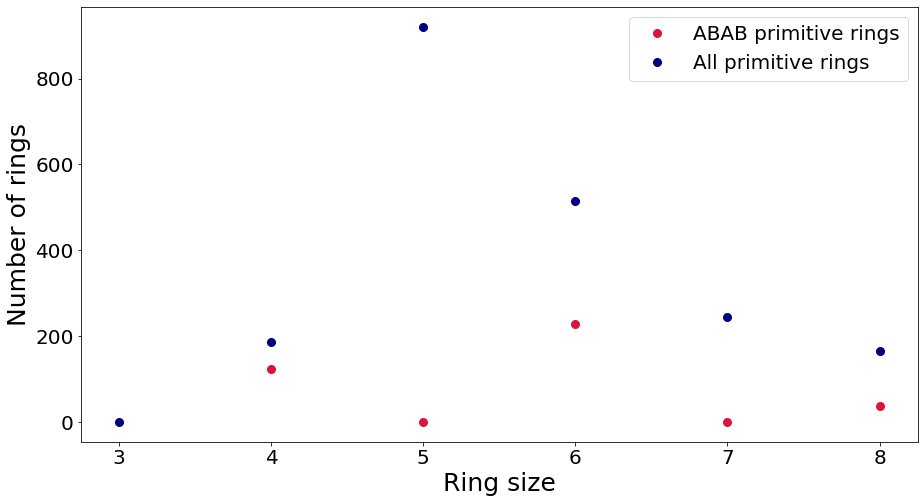

In [5]:
%pylab inline

ABAB_axis=[i+4 for i in range(max_ring_length-3)]
all_axis=[i+3 for i in range(max_ring_length-2)]

alpha=1
plt.figure(figsize=(15,8))
#plt.plot(ABAB_axis,ABAB_cycle_hist,"+",markersize=13,color="crimson",label="ABAB rings",alpha=alpha)
#plt.plot(all_axis,all_cycle_hist,"+",markersize=13,color="navy",label="All rings",alpha=alpha)
plt.plot(ABAB_axis,ABAB_primitive_cycle_hist,"o",markersize=8,color="crimson",label="ABAB primitive rings",alpha=alpha)
plt.plot(all_axis,all_primitive_cycle_hist,"o",markersize=8,color="navy",label="All primitive rings",alpha=alpha)
plt.xlabel("Ring size",fontsize=25)
plt.ylabel("Number of rings",fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
#plt.yscale("log")

A szomszédsági mátrix (lehet ki van törölve, akkor vissza kell hozni) adott elemei között meg kell nézni, hogy a szomszédsági listák elemei közt hány azonos van (edge-shared/corner shared tulajdonság). Ezen felül ha láncot keresünk (pl. tiszta Te) akkor végig kell menni az összes páron, és ha csak tellúrból áll, akkor oké, ha nem, akkor meg kell nézni, van-e alternatív útvonal (all_shortest_paths(G,source=path[j][1][0],target=path[j][1][-1],)). 

In [6]:

AAAAAB,AAAABB,AABAAB,ABAAAB,AAABBB,ABAABB,AABBBB,ABABBB,ABBABB,ABBBBB

(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 196.0, 83.0, 32.0)

In [7]:
ABBB/2+AAAA/4

NameError: name 'AAAA' is not defined

In [ ]:
cycles[:10]

In [ ]:
nx.draw(G, pos=nx.circular_layout(G), node_color='r', edge_color='b')

A legrövidebb utat minden i,j között kiszámolni. Ammi releváns most, az az i,j<6000. egy idő után (kb 20) levágni, és ami marad, arra megnézni, hogy a kapcsoló atomok miből állnak (dimer, te lánc, stb)

In [ ]:
def homo_basis_rings(basis_cycles,ACT): #function of rings and ring type
    basis_cycle_hist=np.zeros(max_ring_length+1) #empty array for histograms
    for i in range(len(basis_cycles)): #for every endpoint
        for j in basis_cycles[i]: #for every cycle
            if(all((np.array(j)-sum(NoA[:ACT]))>=0)==True and all((np.array(j)-sum(NoA[:ACT+1]))<0)==True):#conditon for ring type
                basis_cycle_hist[len(j)]+=1 #adding 1 to the relevant histogram bin, no correction for double counting needed
    return list(np.array(basis_cycle_hist[3:])) #starting with lentgh 3 (others are irrelevant), index 2 contains spam

#function to calculate ABAB rings
def ABAB_basis_rings(basis_cycles):
    max_length=0
    for i in range(len(basis_cycles[0])):
        if(len(basis_cycles[0][i])>max_length):
            max_length=len(basis_cycles[0][i])
    ABAB_basis_cycle_hist=np.zeros(max_length+1) #empty array for histograms
    for i in range(len(basis_cycles)): #for every endpoint
        for j in basis_cycles[i]: #for every cycle
            A_type=[] #list for type A atoms
            B_type=[] #list for type B atoms
            if(len(j)%2==0): #if No atoms in ring is even (condition for ring)
                for k in range(len(j)): # for every element of ring
                    if(k%2==0): #if index is even
                        A_type.append(j[k]) #it is type A then
                    elif(k%2==1): #if index is odd
                        B_type.append(j[k]) #index belongs to type B
                #condition for the types of atoms in list A_type and B_type
                if(all((np.array(A_type)-sum(NoA[:ABAB_types[0]]))>=0)==True and all((np.array(A_type)-sum(NoA[:ABAB_types[0]+1]))<0)==True):#conditon for ring type
                    if(all((np.array(B_type)-sum(NoA[:ABAB_types[1]]))>=0)==True and all((np.array(B_type)-sum(NoA[:ABAB_types[1]+1]))<0)==True):#conditon for ring type
                        ABAB_basis_cycle_hist[len(j)]+=1 #adding 1 to the relevant histogram bin, no correction for double counting needed
                #it can also be the other way (BABA rings)
                elif(all((np.array(B_type)-sum(NoA[:ABAB_types[0]]))>=0)==True and all((np.array(B_type)-sum(NoA[:ABAB_types[0]+1]))<0)==True):#conditon for ring type
                    if(all((np.array(A_type)-sum(NoA[:ABAB_types[1]]))>=0)==True and all((np.array(A_type)-sum(NoA[:ABAB_types[1]+1]))<0)==True):#conditon for ring type
                        ABAB_basis_cycle_hist[len(j)]+=1 #adding 1 to the relevant histogram bin, no correction for double counting needed
    return ABAB_basis_cycle_hist[4:] #return with histogram, starting with length 4

def basis_ring_dist(basis_cycles): #function of rings and ring type
    max_length=0
    for i in range(len(basis_cycles[0])):
        if(len(basis_cycles[0][i])>max_length):
            max_length=len(basis_cycles[0][i])
    all_basis_cycle_hist=np.zeros(max_length+1) #empty array for histograms
    for i in range(len(basis_cycles)): #for every endpoint
        for j in basis_cycles[i]: #for every cycle
            all_basis_cycle_hist[len(j)]+=1 #adding 1 to the relevant histogram bin, no correction for double counting needed
    return list(np.array(all_basis_cycle_hist[3:])) #starting with lentgh 3 (others are irrelevant), index 2 contains spam

basis_cycles=[]
temp=nx.cycle_basis(G)
basis_cycles.append(temp)

In [ ]:
basis_cycle_hist=homo_basis_rings(basis_cycles,ACT) #getting homo rings, starting from length 3
print("Homogeneous type "+str(ACT)+" ring length distribution computed, time: "+str(round(time.time()-start,3)))
print("Type "+str(ACT)+" ring length distribution: "+str(np.round(basis_cycle_hist,2)))

ABAB_basis_cycle_hist= ABAB_basis_rings(basis_cycles) #ABAB rings starting from length 4
print("ABAB ring length distribution evaluated, time: "+str(round(time.time()-start,3)))
print("\nABAB ring length distribution: "+str(np.round(ABAB_basis_cycle_hist,3)))

all_basis_cycle_hist=basis_ring_dist(basis_cycles) #all rings starting from length 3
print("All ring length distribution obtaining done, time: "+str(round(time.time()-start,3)))
print("\nAll ring length distribution: "+str(np.round(all_basis_cycle_hist,3)))

print("\nAnalyses finished. Have a nice day! :)")

In [ ]:
x=[i for i in range(10666)]
plt.plot(x,all_basis_cycle_hist,".")
#plt.yscale("log")
plt.ylim(4,1000)
plt.xlim(-1,10)

In [ ]:
G_ring=nx.Graph()
for i in range(len(cycles)): #for every endpoint
    for j in cycles[i]: #for every cycle
        nx.add_cycle(G_ring,j)

basis_cycles=[]
temp=nx.cycle_basis(G_ring)
basis_cycles.append(temp)

In [ ]:
basis_cycle_hist=homo_basis_rings(basis_cycles,ACT) #getting homo rings, starting from length 3
print("Homogeneous type "+str(ACT)+" ring length distribution computed, time: "+str(round(time.time()-start,3)))
print("Type "+str(ACT)+" ring length distribution: "+str(np.round(basis_cycle_hist,2)))

ABAB_basis_cycle_hist= ABAB_basis_rings(basis_cycles) #ABAB rings starting from length 4
print("ABAB ring length distribution evaluated, time: "+str(round(time.time()-start,3)))
print("\nABAB ring length distribution: "+str(np.round(ABAB_basis_cycle_hist,3)))

all_basis_cycle_hist=basis_ring_dist(basis_cycles) #all rings starting from length 3
print("All ring length distribution obtaining done, time: "+str(round(time.time()-start,3)))
print("\nAll ring length distribution: "+str(np.round(all_basis_cycle_hist,3)))

print("\nAnalyses finished. Have a nice day! :)")

In [ ]:
asd=nx.cycle_basis(G,root=1)
COUNTER=0
for i in range(len(asd)):
    if(len(asd[i])<=12):
        COUNTER+=1
COUNTER

In [ ]:
G_r=nx.Graph()
for i in range(len(cycles)): #for every endpoint
        for j in cycles[i]: #for every cycle
                nx.add_cycle(G_r,j)

len(nx.cycle_basis(G_r))   

In [ ]:
cycle_hist=homo_rings(cycles,ACT) #getting homo rings, starting from length 3
print("Homogeneous type "+str(ACT)+" ring length distribution computed, time: "+str(round(time.time()-start,3)))
print("Type "+str(ACT)+" ring length distribution: "+str(np.round(cycle_hist,2)))

ABAB_cycle_hist= ABAB_rings(cycles) #ABAB rings starting from length 4
print("ABAB ring length distribution evaluated, time: "+str(round(time.time()-start,3)))
print("\nABAB ring length distribution: "+str(np.round(ABAB_cycle_hist,3)))

all_cycle_hist=ring_dist(cycles) #all rings starting from length 3
print("All ring length distribution obtaining done, time: "+str(round(time.time()-start,3)))
print("\nAll ring length distribution: "+str(np.round(all_cycle_hist,3)))
